[ 0.  -0.5  0.   0.   0.   0.   0.   0.   1.   1.   0.   2.   0.   0.
  0.   0.   0.  -0.6  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  -0.6  0.   0.   0.   0.   1.   0. ]
(36,)
(36,)


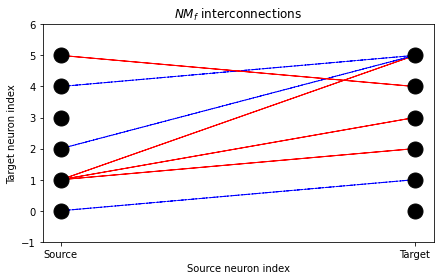

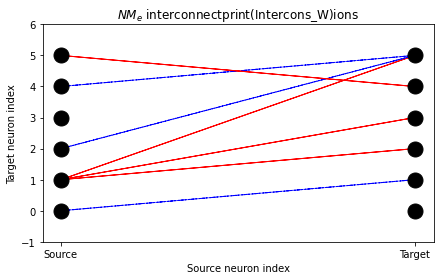

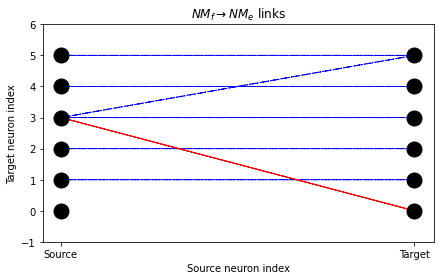

In [1]:
from brian2 import *
import numpy as np
from displayers import *
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

eqs_IJIK = '''
    dv/dt = (0.04*v**2 + 5*v + 140 - u + I + Isyn)/(ms) : 1
    du/dt = a*(b*v-u)/ms : 1
    a : 1
    b : 1
    c : 1
    d : 1
    I : 1
    Isyn : 1
'''
# Interconnections
Intercons = np.array([
    [0, -0.5, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 2],
    [0, 0, 0, 0, 0, -0.6],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, -0.6],
    [0, 0, 0, 0, 1, 0]
])

Externlinks = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, -1, 0, 0, 0, 0],
    [0, 0, -1, 0, 0, 0],
    [1, 0, 0, -1, 0, -1],
    [0, 0, 0, 0, -1, 0],
    [0, 0, 0, 0, 0, -1]
    
])

# Convert matrix to array i - number of line. j - number of column.
Intercons_W = np.asarray(Intercons).reshape(-1)
print(Intercons_W)
print(np.shape(Intercons_W))
Externlinks_W = np.asarray(Externlinks).reshape(-1)

start_scope()
N = len(Intercons)

#Creating flexor neuro-module
NM_f = NeuronGroup(N, eqs_IJIK, threshold = 'v>30',reset="v=c;u=u+d", method='euler')
NM_f.a = 0.1; NM_f.b = 0.2; NM_f.c = -65; NM_f.d = 8; NM_f.v = NM_f.c
NM_f.d[0] = 2; NM_f.c[0]=-50; NM_f.d[1] = 4; NM_f.c[1]=-65
ampl = 5
NM_f.I[0]=0; NM_f.I[1] = ampl; NM_f.I[2] = ampl/2; NM_f.I[3] = ampl/2;
NM_f.I[4] = ampl/2

# NM_f inter connections
NM_f_syn = Synapses(NM_f, NM_f, "w:1", on_pre="v_post -= w*v_pre", delay=0.5*ms)
NM_f_syn.connect()
print(np.shape(NM_f_syn.w))
NM_f_syn.w=Intercons_W*0.2

#Creating extenzor neuro-module
NM_e = NeuronGroup(N, eqs_IJIK, threshold = 'v>30',reset="v=c;u=u+d", method='euler')
NM_e.a = 0.1; NM_e.b = 0.2; NM_e.c = -65; NM_e.d = 8; NM_e.v = NM_f.c
NM_e.d[0] = 2.3; NM_e.c[0]=-50; NM_e.d[1] = 4; NM_e.c[1]=-65
ampl = 5
NM_e.I[0]=0; NM_e.I[1] = ampl; NM_e.I[2] = ampl/2; NM_e.I[3] = ampl/2;
NM_e.I[4] = ampl/2
visualise_connectivity(NM_f_syn, r"$NM_f$ interconnections")

#NM_e inter connections
NM_e_syn = Synapses(NM_e, NM_e, "w:1", on_pre="v_post -= w*v_pre", delay=0.5*ms)
NM_e_syn.connect()
NM_e_syn.w=Intercons_W*0.2
visualise_connectivity(NM_e_syn, r"$NM_e$ interconnectprint(Intercons_W)ions")

#NMS extern connectivity
NMS_syn = Synapses(NM_f, NM_e, "w:1", on_pre="v_post -= w*v_pre", delay=0.5*ms)
NMS_syn.connect()
NMS_syn.w=Externlinks_W*0.05
visualise_connectivity(NMS_syn, r"$NM_f \rightarrow NM_e$ links")

#NMS_syn = Synapses(NM_e, NM_f, "w:1", on_pre="v_post -= w*v_pre", delay=1*ms)
#NMS_syn.connect()
#NMS_syn.w=Externlinks_W*0.2
#visualise_connectivity(NMS_syn, r"$NM_e \rightarrow NM_f$ links")


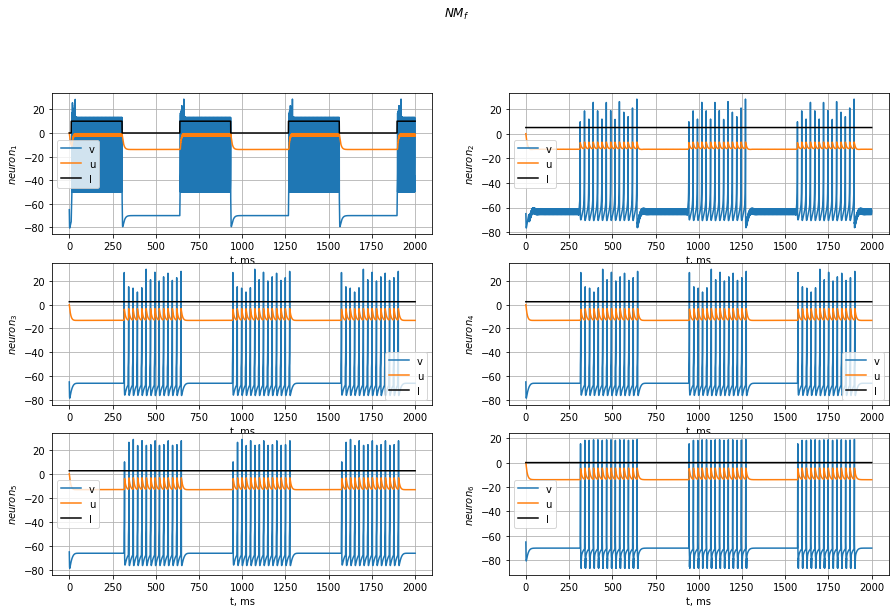

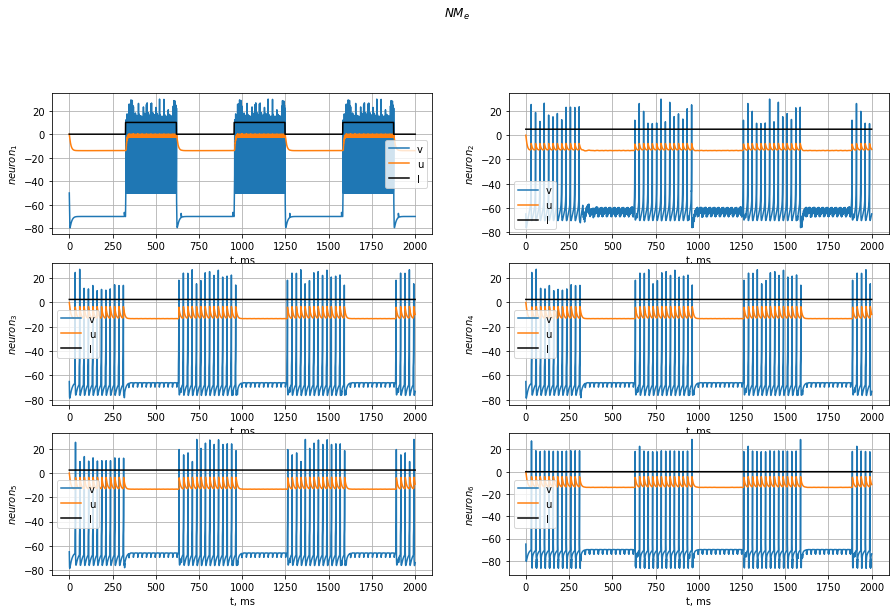

In [2]:
##Simulation
T = 2*second
minV = 5
@network_operation(dt=1*ms)
def change_I0(t):
    NM_f.I[0] = 10*((sin(t*10*Hz))>0.1)
    NM_e.I[0] = 10*((sin(t*10*Hz))<-0.1)
NMf_monitor = StateMonitor(NM_f, ['u', 'v', 'I'], record=True)
NMe_monitor = StateMonitor(NM_e, ['u', 'v', 'I'], record=True)

run(T)
draw_sym(NMf_monitor, r"$NM_f$")
draw_sym(NMe_monitor, r"$NM_e$")